In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..\..\..').resolve())
sys.path.append(parent_path)

In [86]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import (mission_completion_query,
    mission_completion,
    _mission_completes_details)
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from itertools import zip_longest

In [54]:
replays = get_parsed_replays(lambda g: g.event == 'Winter Cup 2020')

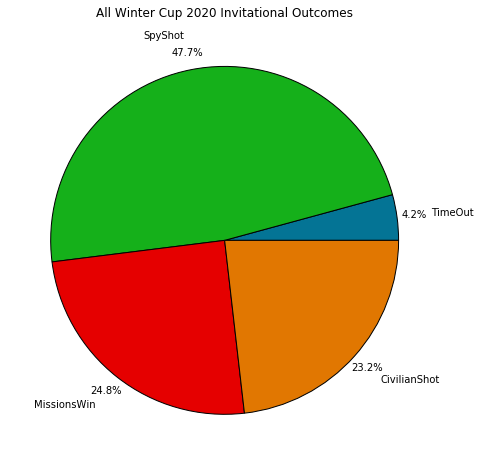

,WinType.TimeOut,WinType.SpyShot,WinType.MissionsWin,WinType.CivilianShot
NaN,46,519,270,252


In [55]:
game_outcomes(
    replays,
    axis_properties=AxisProperties(title="All Winter Cup 2020 Invitational Outcomes")
).frame

### Game Counts

In [83]:
x = sorted(Counter((r.division, r.week, tuple(sorted([r.spy, r.sniper]))) for r in replays).items(), key=lambda x: (x[0][0], x[0][1], x[0][2]))
y = [(_x[0][0], _x[0][1], _x[0][2], _x[1]) for _x in x]
Counter([_y[0] for _y in y])

Counter({'Blitzen': 9,
         'Bracket': 16,
         'Coment': 10,
         'Cupid': 10,
         'Dancer': 8,
         'Dasher': 10,
         'Donner': 10,
         'Prancer': 10,
         'Vixen': 10})

## Group Stage Most Picked / Banned

In [84]:
BigBois = "The Big Bois"
EyeInSky = "Eye in the Sky"
CouldYouSee = "Could you see that?"

In [85]:
map_groups = {
    BigBois: {'Terrace','Gallery','Veranda','Library'},
    EyeInSky: {'Balcony','Pub','Courtyard','Moderne'},
    CouldYouSee: {'High-Rise','Ballroom','Aquarium','Teien'},
}

In [87]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [91]:
def identify_groups(played_venues):
    picked_groups = set()
    bans = set()
    for venue in played_venues:
        for group in [BigBois, EyeInSky, CouldYouSee]:
            if venue in map_groups[group]:
                picked_groups.add(group)
        if len(picked_groups) == 2:
            break
            
    for group in picked_groups:
        for venue in map_groups[group]:
            bans.add(venue)
            
    for venue in played_venues:
        bans.discard(venue)
        
    return picked_groups, bans

In [92]:
sorted_group_replays = sorted([r for r in replays if r.division != 'bracket'], key=lambda g: (g.division, sorted([g.spy, g.sniper]), g.start_time))
twelve_game_sets = Counter((tuple(sorted([g.spy, g.sniper])) for g in sorted_group_replays))
twelve_set_pairs = [k for k,v in twelve_game_sets.items() if v == 12]
only_full_set_replays = [g for g in sorted_replays if tuple(sorted([g.spy, g.sniper])) in twelve_set_pairs]

In [93]:
all_group_picks = Counter()
all_bans = Counter()

for g in grouper(only_full_set_replays, 12):
    groups, bans = identify_groups([r.venue for r in g])
    all_group_picks.update(Counter(groups))
    all_bans.update(Counter(bans))
    

In [94]:
all_group_picks.most_common()

[('The Big Bois', 63), ('Could you see that?', 43), ('Eye in the Sky', 42)]

In [95]:
all_bans.most_common()

[('Balcony', 19),
 ('Veranda', 18),
 ('Terrace', 17),
 ('Teien', 17),
 ('Courtyard', 16),
 ('Aquarium', 12),
 ('High-Rise', 12),
 ('Gallery', 11),
 ('Library', 10),
 ('Moderne', 10),
 ('Ballroom', 4),
 ('Pub', 3)]

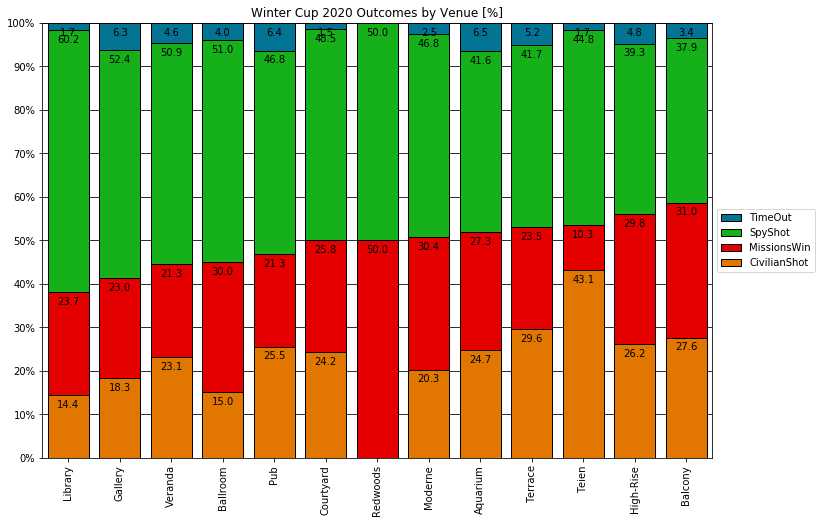

,Library,Gallery,Veranda,Ballroom,Pub,Courtyard,Redwoods,Moderne,Aquarium,Terrace,Teien,High-Rise,Balcony
WinType.TimeOut,0.016949,0.063492,0.046296,0.04,0.063830,0.015152,0.0,0.025316,0.064935,0.052174,0.017241,0.047619,0.034483
WinType.SpyShot,0.601695,0.523810,0.509259,0.51,0.468085,0.484848,0.5,0.468354,0.415584,0.417391,0.448276,0.392857,0.379310
WinType.MissionsWin,0.237288,0.230159,0.212963,0.30,0.212766,0.257576,0.5,0.303797,0.272727,0.234783,0.103448,0.297619,0.310345
WinType.CivilianShot,0.144068,0.182540,0.231481,0.15,0.255319,0.242424,0.0,0.202532,0.246753,0.295652,0.431034,0.261905,0.275862


In [99]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [%]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

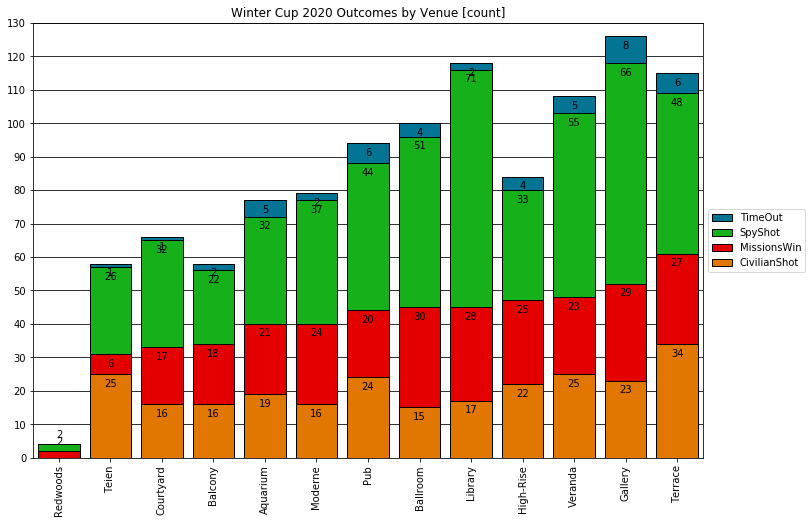

,Redwoods,Teien,Courtyard,Balcony,Aquarium,Moderne,Pub,Ballroom,Library,High-Rise,Veranda,Gallery,Terrace
WinType.TimeOut,0,1,1,2,5,2,6,4,2,4,5,8,6
WinType.SpyShot,2,26,32,22,32,37,44,51,71,33,55,66,48
WinType.MissionsWin,2,6,17,18,21,24,20,30,28,25,23,29,27
WinType.CivilianShot,0,25,16,16,19,16,24,15,17,22,25,23,34


In [100]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [count]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

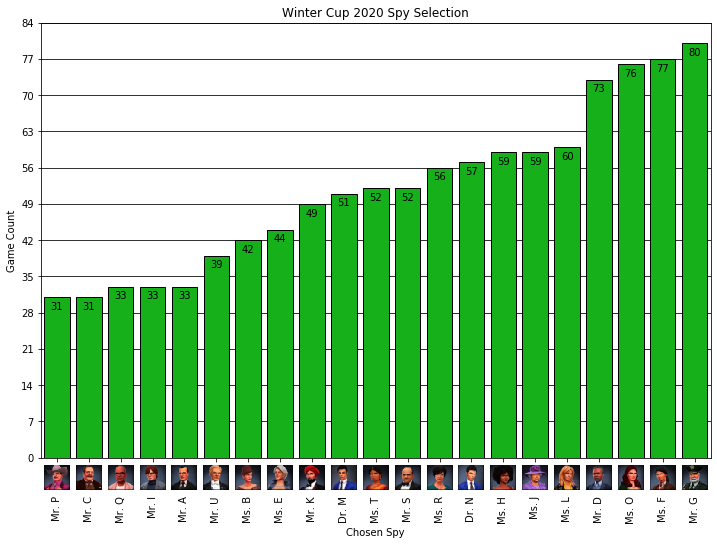

In [75]:
_ = spy_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Spy Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Spy",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

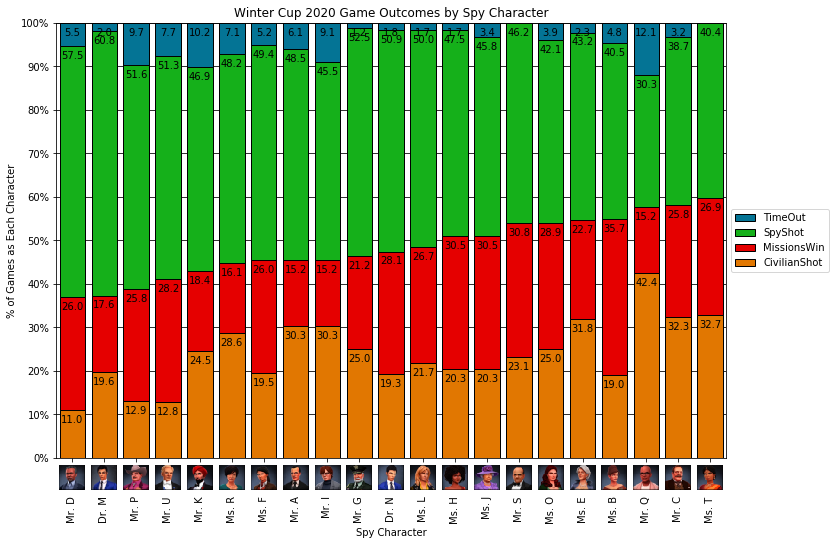

In [76]:
_ = game_outcomes(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Game Outcomes by Spy Character",
        x_axis_portrait=True,
        y_axis_label="% of Games as Each Character",
        x_axis_label="Spy Character",
        data_label_style=PlotLabelStyle.Plain,
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: determine_character_in_role(g, Roles.Spy),
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True
    )
)

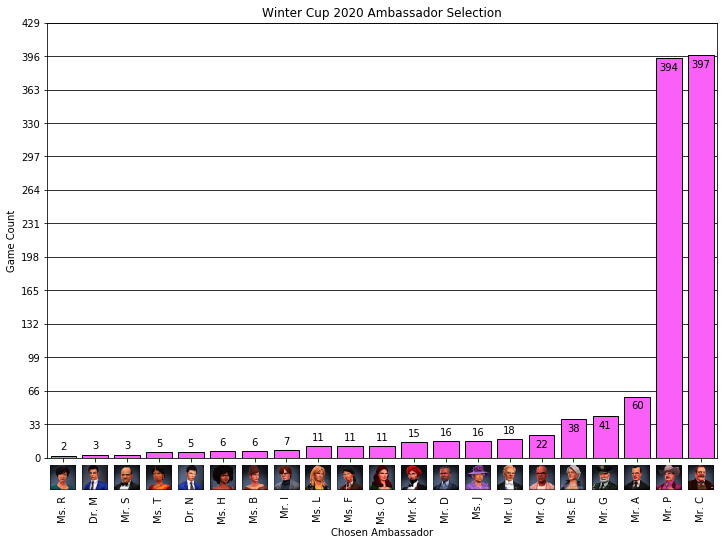

In [77]:
_ = amba_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Ambassador Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Ambassador",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

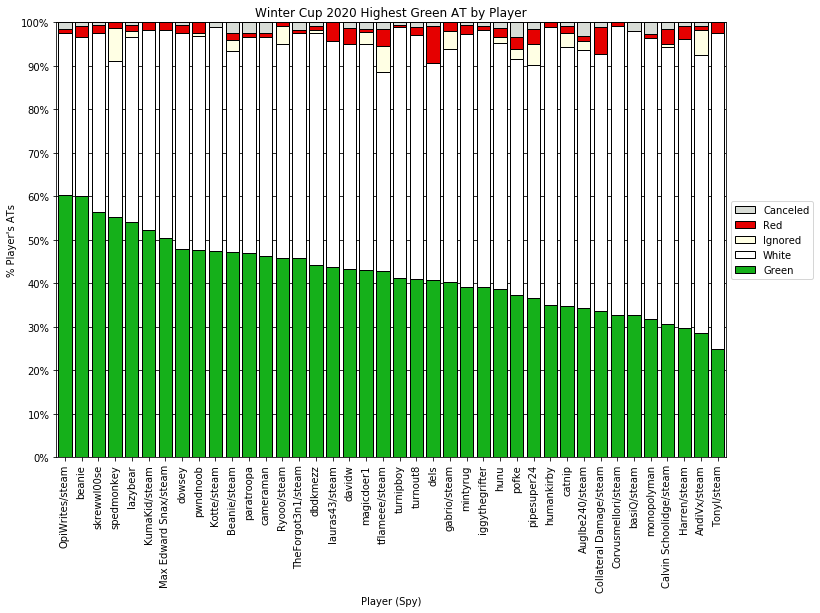

In [78]:
_ = action_test_percentages(
    replays,
    axis_properties = AxisProperties(
        title='Winter Cup 2020 Highest Green AT by Player',
        x_axis_label='Player (Spy)',
        y_axis_label='% Player\'s ATs',
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=lambda name_series: -name_series[1][ActionTest.Green],
        reverse_primary_order=True,
        percent_normalized_data=True)    
)

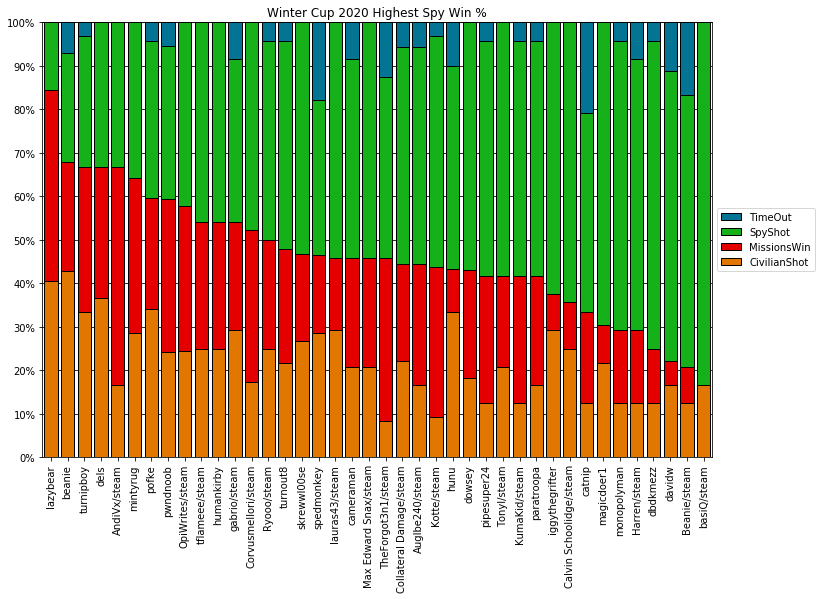

In [79]:
spy_winr = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sort_by_spy_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Spy Win %")
)

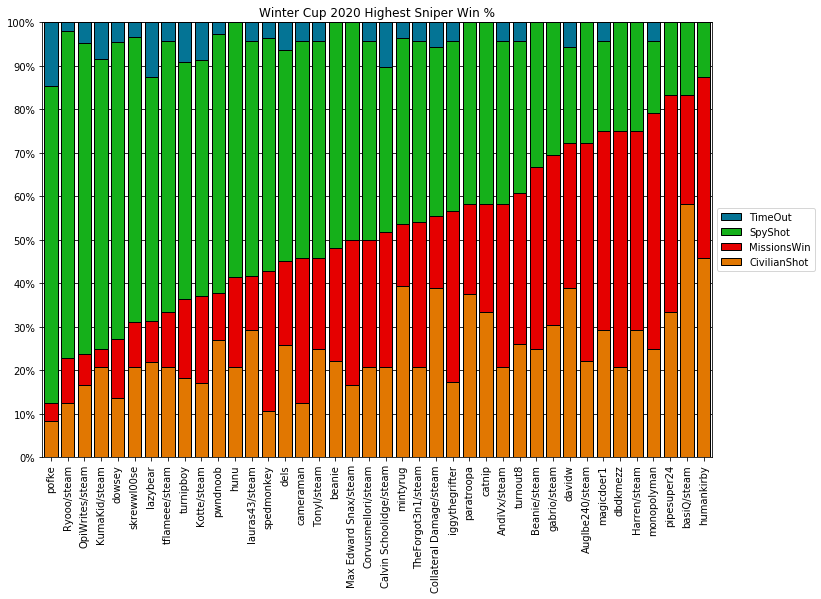

In [80]:
_ = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.sniper,
        secondary_order=sort_by_sniper_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Sniper Win %")
)

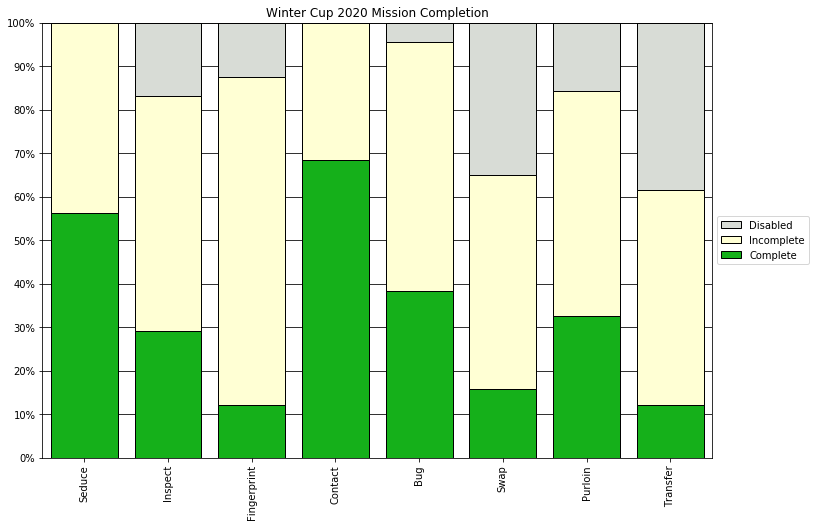

In [81]:
mission_completion(replays, "Winter Cup 2020 Mission Completion")

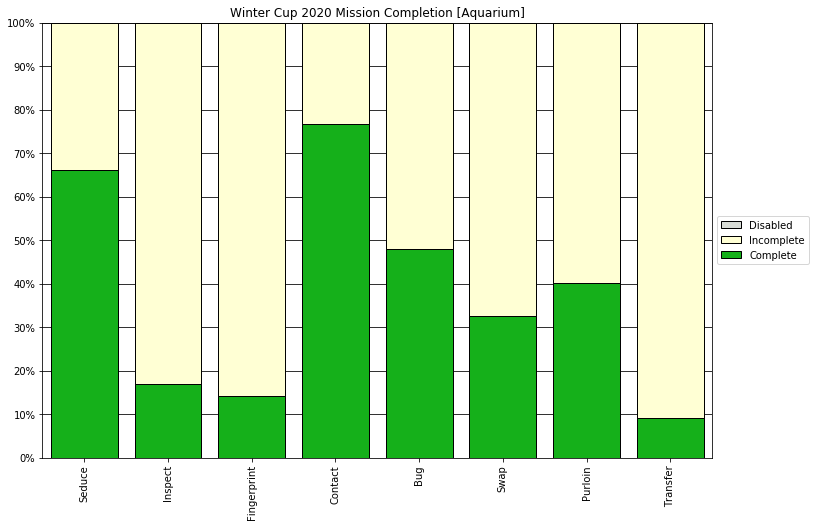

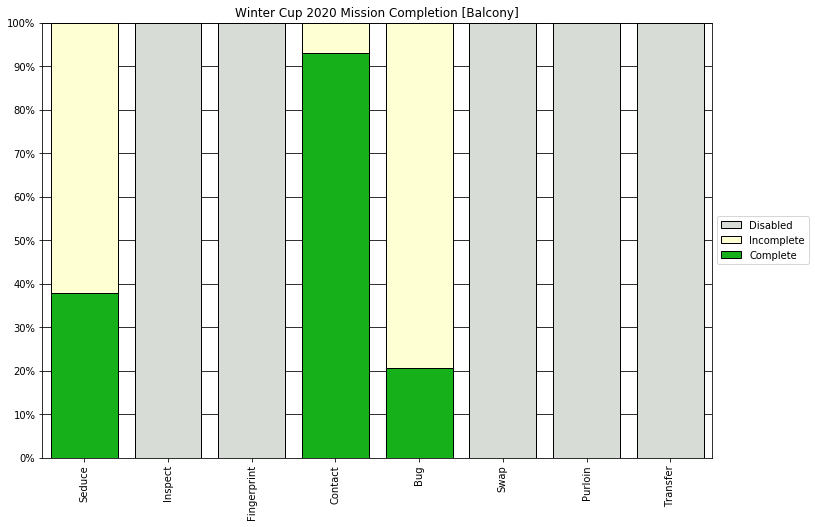

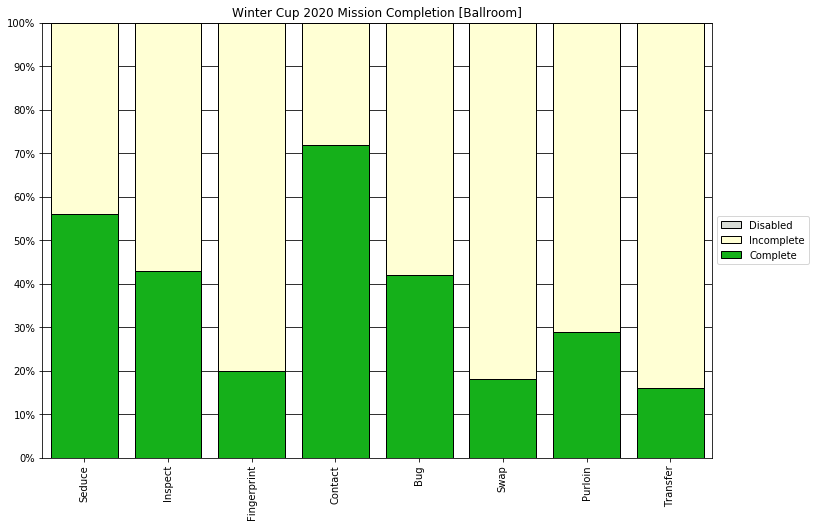

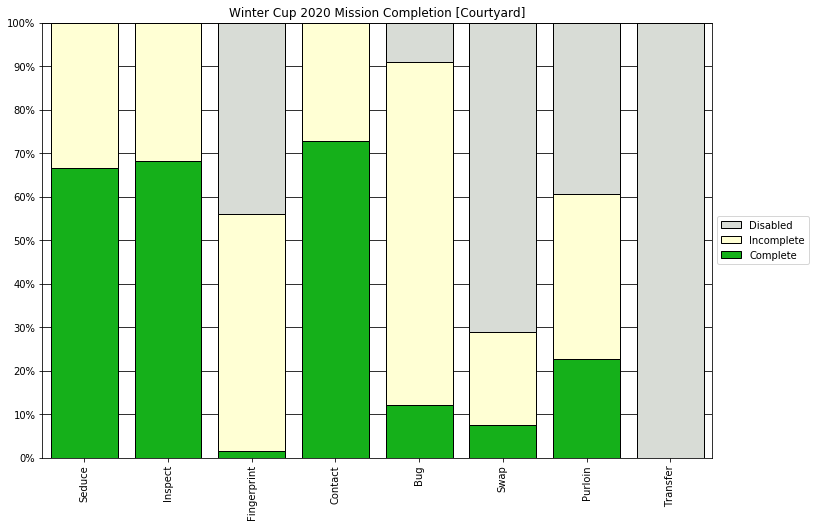

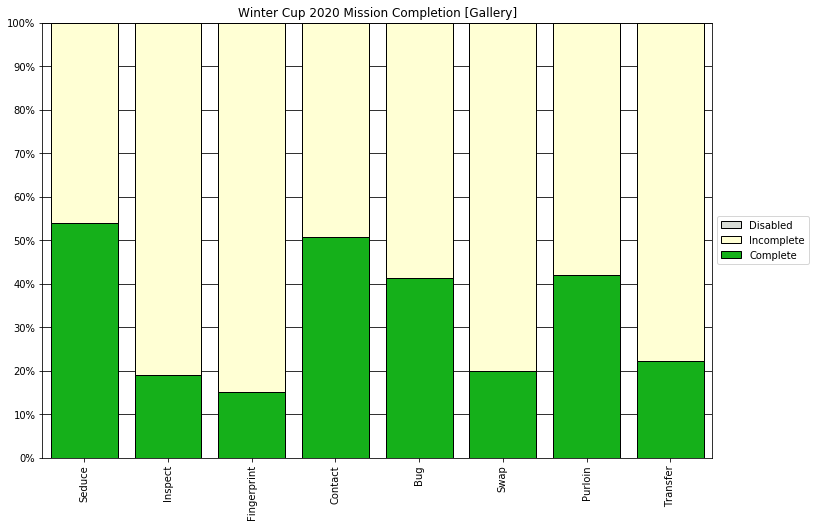

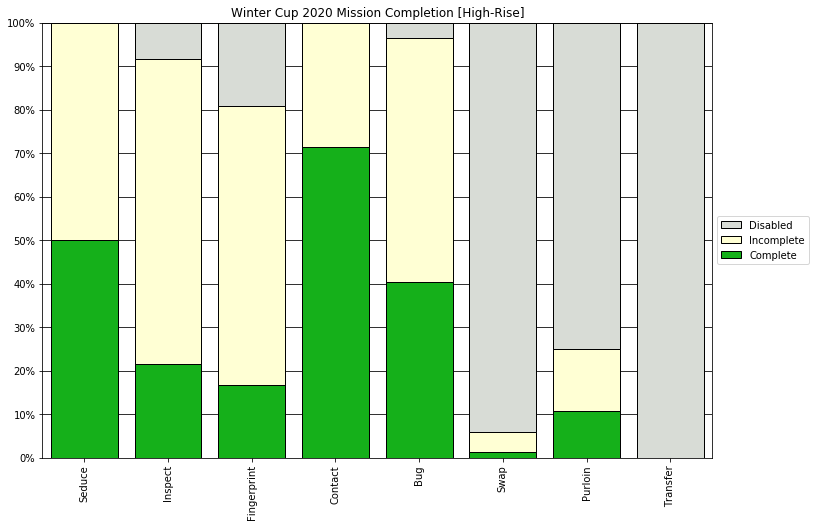

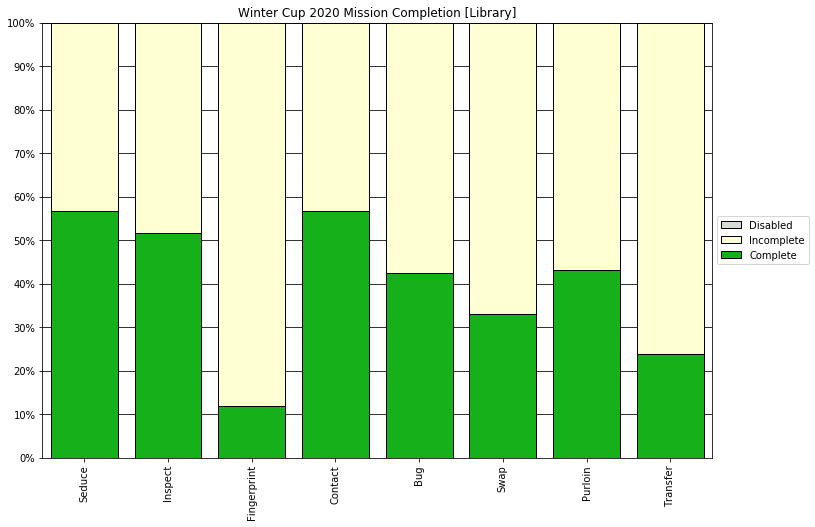

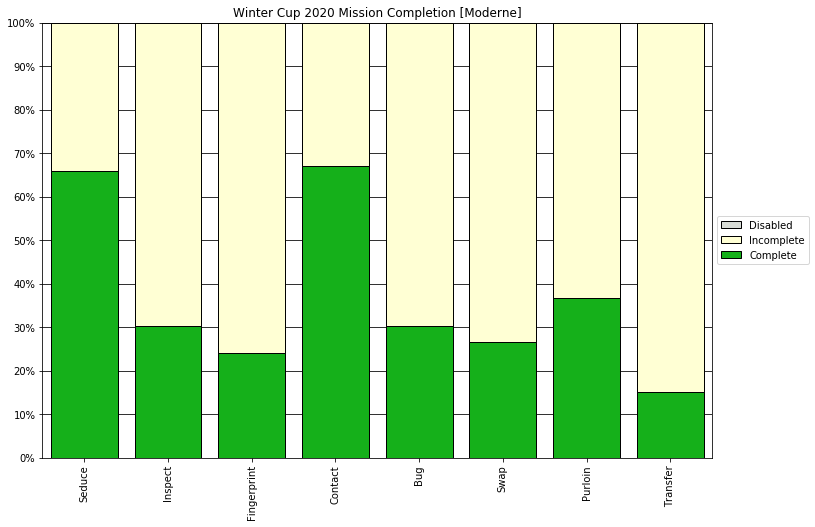

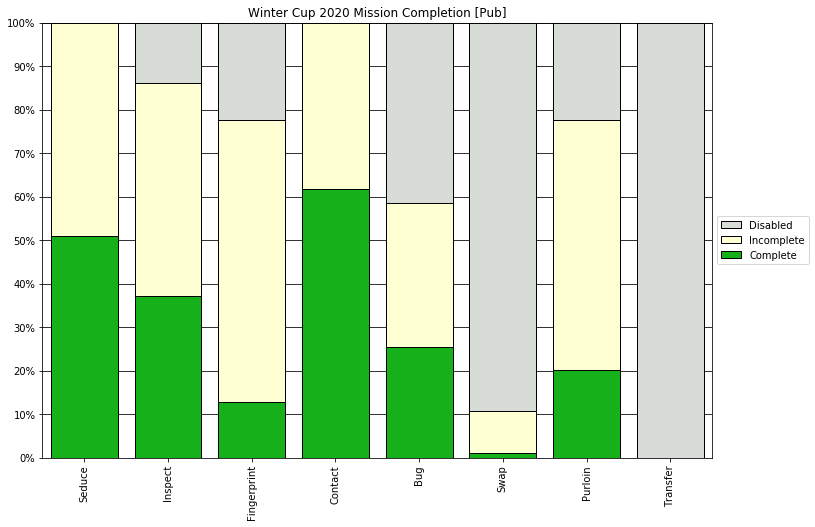

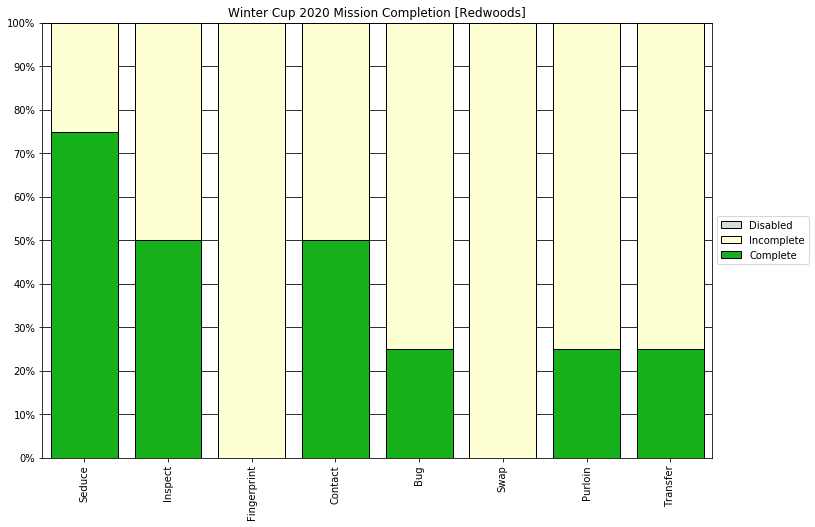

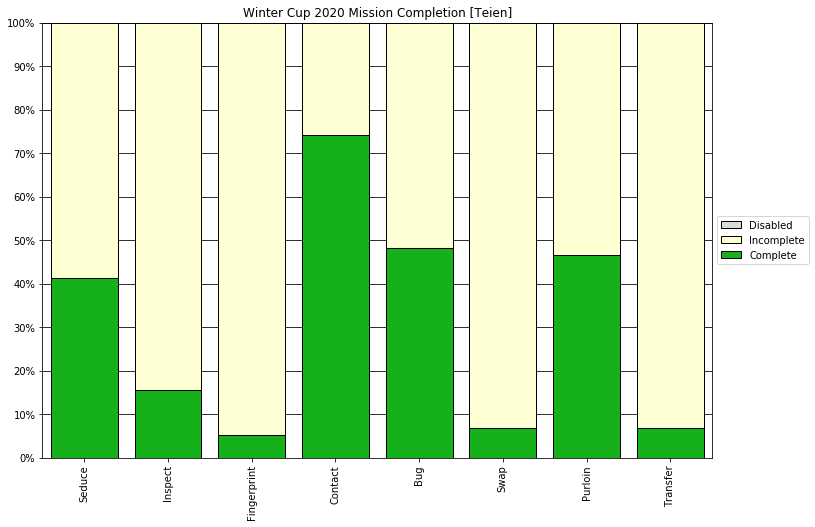

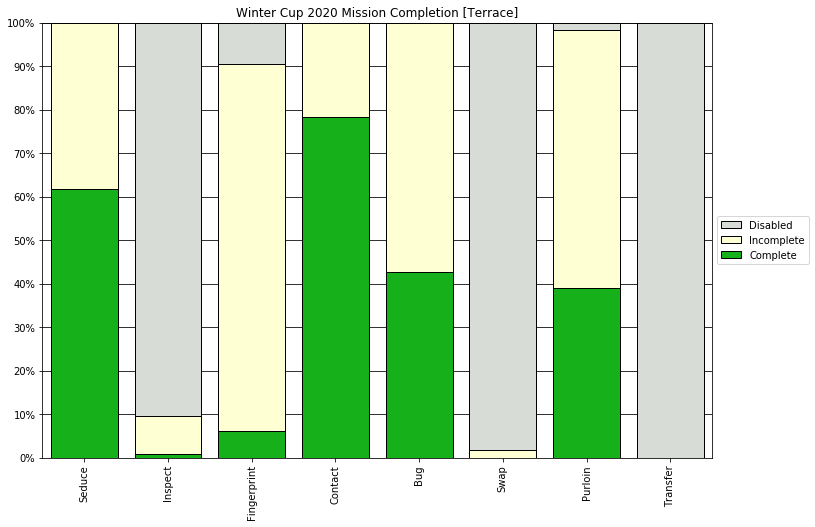

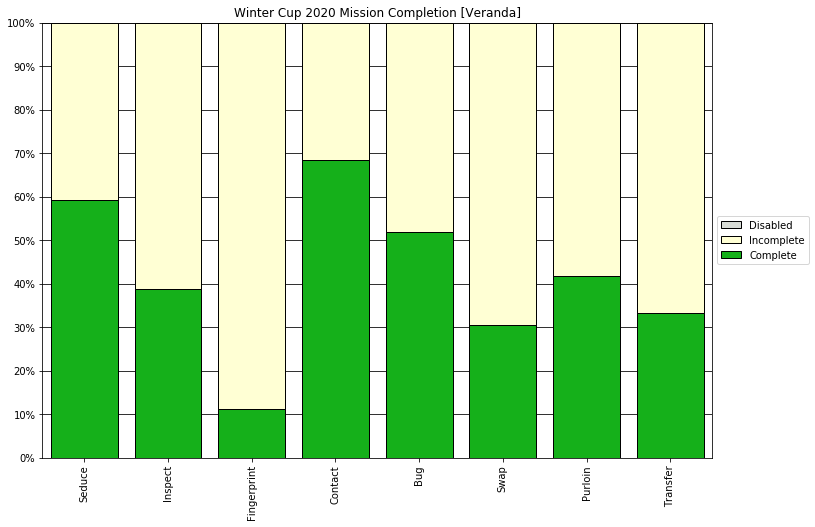

In [82]:
for venue in sorted(set([g.venue for g in replays])):
    mission_completion(list(filter(lambda g: g.venue == venue, replays)), f"Winter Cup 2020 Mission Completion [{venue}]")